## Le deuxième objectif du projet consiste à expliciter et à implémenter 2 approches de transfer learning : 
**A : l’utilisation des features d’un DL avant la couche dense comme représentation des images puis apprentissage d’un modèle de ML “classique”** \
**B : fine-tuning d'un modèle existant à de nouvelles données**

# Transfer learning de type A 

In [1]:
import os

## Avec Resnet50

In [3]:
#TRANSFER LEARNING
#The authors did that : using feature extraction from ImageNet VGG16 - library : keras
#We do : using feature extraction from ImageNet RESNet50 - library : pytorch

import torch
import torch.nn as nn
import torchvision.models as models

conv_base = models.resnet50(pretrained=True)
layers = list(conv_base.children())[:-2] #on retire les couches denses #on a un poids de 2048 
conv_base = nn.Sequential(*layers) 
conv_base.eval()

/home/pierre/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pierre/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/pierre/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [4]:
#Method 1: Fast feature extraction without data augmentation
#Run the conv_base on the dataset and save as Numpy array on disk
#Then build the dense layer on this
#This is faster to run, but we cannot augment the data

import torchvision.transforms as transforms
from torchvision import datasets

train_dir = "./train_another"
validation_dir = "./validation_another"
test_dir = "./test"
#transform
data_transform = transforms.Compose([
    transforms.Resize(150,150),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_dataset = datasets.ImageFolder(train_dir, transform=data_transform)
validation_dataset = datasets.ImageFolder(validation_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

In [4]:
#define extract_features
#generators yield data indefinitely
#have to break after we have seen every image once
#try parallized (cuda)

import torch.cuda


def extract_features(directory, sample_count, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #on impute les poids de Resnet
    
    features = torch.zeros(size=(sample_count,2048,5,5), dtype=torch.float32).to(device)
    labels = torch.zeros(size=(sample_count,), dtype=torch.long).to(device)


    data_transform = transforms.Compose([
        transforms.Resize((150,150)), #dimension de la cible
        transforms.ToTensor()
    ])

    image_dataset = datasets.ImageFolder(root=directory, transform=data_transform)
    data_loader = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size, shuffle=False)

    i = 0
    for inputs_batch, labels_batch in data_loader:
        inputs_batch, labels_batch = inputs_batch.to(device), labels_batch.to(device)
        with torch.no_grad():
            features_batch = conv_base(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

In [5]:
train_features, train_labels = extract_features(train_dir, 10000, 20)
validation_features, validation_labels = extract_features(validation_dir, 2000, 20) #batchs(20) à remettre en pyTorch
test_features, test_labels = extract_features(test_dir, 2000, 20)

In [6]:
#Etape de flatten
train_features = train_features.reshape(10000, 2048*5*5)
validation_features = validation_features.reshape(2000, 2048*5*5)
test_features = test_features.reshape(2000, 2048*5*5)

Epoch [10/30], Loss: 0.4075
Epoch [20/30], Loss: 0.3325
Epoch [30/30], Loss: 0.2965


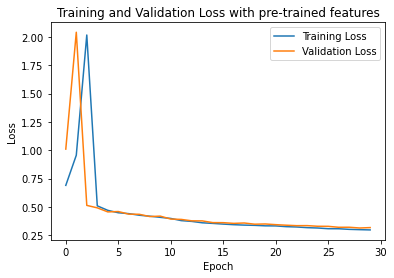

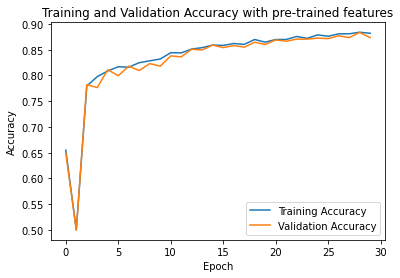

In [19]:
#define the densely connected layer
#import Optimizers
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.fc1 = nn.Linear(2048*5*5, 256) #256 comme les chercheurs
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu' #pour activer la parallélisation
model = DenseNet().to(device)
criterion = nn.BCELoss() #Binary cross Entropy
optimizer = optim.RMSprop(model.parameters(), lr=2e-5) #RMSprop

train_labels = train_labels.reshape(-1, 1).float()
validation_labels = validation_labels.reshape(-1, 1).float()

# Initialize lists to store training and validation loss and accuracy
train_loss_values = []
train_accuracy_values = []
validation_loss_values = []
validation_accuracy_values = []

# Training loop
for epoch in range(30):
    # Forward pass
    outputs = model(train_features)
    loss = criterion(outputs, train_labels)
    train_loss_values.append(loss.item())
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Calculate the accuracy on the training set
    with torch.no_grad():
        train_outputs = model(train_features)
        train_predicted = (train_outputs > 0.5).float()
        train_accuracy = (train_predicted == train_labels).float().mean()
        train_accuracy_values.append(train_accuracy.item())
    
    # Calculate the accuracy on the validation set
    with torch.no_grad():
        validation_outputs = model(validation_features)
        validation_predicted = (validation_outputs > 0.5).float()
        validation_loss = criterion(validation_outputs, validation_labels)
        validation_loss_values.append(validation_loss.item())
        validation_accuracy = (validation_predicted == validation_labels).float().mean()
        validation_accuracy_values.append(validation_accuracy.item())
    
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 30, loss.item()))

#Plot the loss values
plt.figure()
sns.lineplot(x=range(30), y=train_loss_values, label='Training Loss')
sns.lineplot(x=range(30), y=validation_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with pre-trained features')
plt.legend()

#Plot the accuracy values
plt.figure()
sns.lineplot(x=range(30), y=train_accuracy_values, label='Training Accuracy')
sns.lineplot(x=range(30), y=validation_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with pre-trained features')
plt.legend()

plt.show()

#Le modèle avec RESNET 50 a une accuracy légèrement plus faible pour l'accuracy et légèrement plus élevée pour la loss
#(89% vs 92% pour l'accuracy et 0.25 vs 0.18)

In [27]:
#save the model with pretrained features in Numpy array (no data augmentation)
torch.save(model.state_dict(), 'tomnod_transfer_RESNET.pt')

# ALEXNET

## Utilisation d'un Random Forest sur les features extract

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import os

In [2]:
conv_base_all = torchvision.models.alexnet(pretrained=True)

/home/pierre/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pierre/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
data_transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
batch_size = 20

In [4]:
train_dataset = torchvision.datasets.ImageFolder(root='./train_another', transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)

validation_dataset = torchvision.datasets.ImageFolder(root='./validation_another', transform=data_transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

test_dataset = torchvision.datasets.ImageFolder(root='./test', transform=data_transform)
test_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

test_dataset_unbalanced = torchvision.datasets.ImageFolder(root='./test_another', transform=data_transform)
test_loader_unbalanced = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [5]:
train_classes = len(os.listdir('./train_another'))
validation_classes = len(os.listdir('./validation_another'))
test_classes = len(os.listdir('./test'))
test_classes_unbalanced = len(os.listdir('./test_another'))

print("Found {} images  belonging to {} classes.".format(len(train_dataset), train_classes))
print("Found {} images  belonging to {} classes.".format(len(validation_dataset), validation_classes))
print("Found {} images  belonging to {} classes.".format(len(validation_dataset), test_classes))
print("Found {} images  belonging to {} classes.".format(len(test_dataset_unbalanced), test_classes_unbalanced))

Found 10000 images  belonging to 2 classes.
Found 21000 images  belonging to 4 classes.
Found 21000 images  belonging to 2 classes.
Found 9000 images  belonging to 2 classes.


In [6]:
#try transfer learning type A 
#using feature extraction from AlexNet
import torch.nn as nn
import torchvision.models as models
conv_base = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

layers = list(conv_base.children())[:-2] #we only keep the features part

#we should put [:-1] if we want to add this layer (avgpool): AdaptiveAvgPool2d(output_size=(6, 6)

conv_base = nn.Sequential(*layers) 

#conv_base.eval()

In [7]:
# Freeze model weights
for param in conv_base.parameters():
    param.requires_grad = False

In [8]:
from torch.utils.data import DataLoader

def extract_features(directory, sample_count, conv_base, batch_size, datagen):
    features = torch.zeros(size=(sample_count, 256 * 3 * 3))
    labels = torch.zeros(size=(sample_count,))
    
    dataloader = DataLoader(datagen, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for i, (inputs_batch, labels_batch) in enumerate(dataloader):
            features_batch = conv_base(inputs_batch)
            features[i * batch_size: (i + 1) * batch_size] = features_batch.view(batch_size, -1)
            labels[i * batch_size: (i + 1) * batch_size] = labels_batch
            if (i + 1) * batch_size >= sample_count: # Stop when all samples have been extracted
                break
    return features, labels

In [9]:
train_dir='./train_another'
validation_dir='./validation_another'
test_dir='./test'
testunbalanced_dir='./test_another' #9000

In [12]:
datagen_train = torchvision.datasets.ImageFolder(root=train_dir, transform=data_transform)
train_features, train_labels = extract_features(train_dir, 10000, conv_base,20,datagen_train)
datagen_val=torchvision.datasets.ImageFolder(root=validation_dir, transform=data_transform)
validation_features, validation_labels = extract_features(validation_dir, 2000, conv_base,20,datagen_val)
datagen_test=torchvision.datasets.ImageFolder(root=test_dir, transform=data_transform)
test_features, test_labels = extract_features(test_dir, 2000, conv_base,20,datagen_test)
datagen_unbalanced = torchvision.datasets.ImageFolder(testunbalanced_dir, transform=data_transform)
testunbalanced_features, testunbalanced_labels = extract_features(testunbalanced_dir, 9000,conv_base,20, datagen_unbalanced)
testunbalanced_features = np.reshape(testunbalanced_features, (9000, 3*3*256))

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

RF = RandomForestClassifier(max_depth=10, random_state=42)
RF.fit(train_features,train_labels)

RandomForestClassifier(max_depth=10, random_state=42)

In [14]:
#balanced validation set 
score4 = RF.score(validation_features, validation_labels)
print("Validation acc = ", score4)

Validation acc =  0.882


In [15]:
#test set 
score5 = RF.score(test_features, test_labels)
print("Test acc = ", score5)

Test acc =  0.9255


In [16]:
#test unbalanced set 
score6 = RF.score(testunbalanced_features, testunbalanced_labels)
print("Test unbalanced acc = ", score6)

Test unbalanced acc =  0.8672222222222222


## Avec un SVM

In [17]:
from sklearn import svm

In [18]:
svm = svm.SVC()
svm.fit(train_features, train_labels)

SVC()

In [21]:
#balanced validation set 
svm_score_val = svm.score(validation_features, validation_labels)
print("Validation acc = ", svm_score_val)

Validation acc =  0.9415


In [24]:
#test set 
svm_score_test = svm.score(test_features, test_labels)
print("Test acc = ", svm_score_test)

Test acc =  0.955


In [25]:
#test unbalanced set 
svm_score_unba = svm.score(testunbalanced_features, testunbalanced_labels)
print("Test unbalanced acc = ", svm_score_unba)

Test unbalanced acc =  0.9331111111111111


# Transfer learning de type B

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

import torch.cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_base = models.vgg16(pretrained=True) # pre-trained model
conv_base = conv_base.to(device)
conv_base = torch.nn.Sequential(*list(conv_base.children())[:-2]) # remove the last layer

from torchsummary import summary
summary(conv_base, (3, 150, 150))

/home/pierre/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pierre/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [20]:

#data augmentation with the same parameters used by the scientists
#freeze the paramters of the pre-trained network

for param in conv_base.parameters():
    param.requires_grad = False # les gradients ne seront pas calculés lors de la phse d'entaînement pour ces paramtères


# Add custom fully connected layers
class CustomClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_base = conv_base
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4*4*512, 512) #25088, poids de la dernière couche
        self.fc2 = nn.Linear(512, 20)
        self.dropout = nn.Dropout(0.4)
        self.fc3 = nn.Linear(20,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_base(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = CustomClassifier().to(device)

In [15]:
from torchsummary import summary
summary(model, (3, 150, 150))

torch.Size([2, 3, 150, 150])
torch.Size([2, 512, 4, 4])
torch.Size([2, 8192])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 20])
torch.Size([2, 20])
torch.Size([2, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]     

In [17]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns

#data augmentation   
train_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(1, 1), shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
])

train_dataset = torchvision.datasets.ImageFolder(root='./train_another', transform=train_datagen)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)

validation_dataset = torchvision.datasets.ImageFolder(root='./validation_another', transform=val_datagen)
validation_dataloader = DataLoader(validation_dataset, batch_size=20, shuffle=True)    

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# Define the loss function and the optimizer, with the same parameters as the scientists implemented

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss() #Binary cross-entrpoy
optimizer = optim.RMSprop(model.parameters(), lr=2e-5) 

for epoch in range(30):
    running_loss = 0.0
    accuracy = 0.0
    for i, data in enumerate(tqdm(train_dataloader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1,1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)

    with torch.no_grad():
        val_loss = 0.0
        accuracy_val = 0

        start = time.perf_counter()
        for val_data in validation_dataloader:
            val_inputs, val_labels = val_data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels.float().view(-1,1)).item()
            accuracy_val += (torch.round(val_outputs) == val_labels.float().view(-1,1)).sum().item() / len(val_labels)
        val_loss /= len(validation_loader)
        accuracy_val /= len(validation_loader)
        history['loss'].append(running_loss / 100)
        history['val_loss'].append(val_loss)
        history['acc'].append(accuracy / 100)
        history['val_acc'].append(accuracy_val)
        running_loss = 0.0
        accuracy = 0.0
        if i % 20 == 0: # Only print every 20 iterations
            print('Epoch {}/30, 500/500 [==============================] - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format(
                epoch + 1, history['loss'][-1], history['acc'][-1], history['val_loss'][-1], history['val_acc'][-1]))
end = time.perf_counter()

100%|██████████| 500/500 [12:11<00:00,  1.46s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy


plt.plot(epoch, history['acc'], 'bo', label='Training acc')
plt.plot(epoch, history['val_acc'], 'r', label='Validation acc')
plt.title('Training and validation accuracy with data aug and dropout (Adam)')
plt.legend()
plt.figure()
epoch = range(1, len(history['loss']) + 1)
plt.plot(epoch, history['loss'], 'bo', label='Training loss')
plt.plot(epoch, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss with data aug and dropout (Adam)')
plt.legend()


plt.show()